In [14]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Utility functions

# Function to read JSON files
def read_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Function to extract relevant information from a single experiment result
def extract_result_info(result):
    return {
        'pooling_strategy': result['pooling_strategy'],
        'learning_rate': result['learning_rate'],
        'hidden_dropout_prob': result['hidden_dropout_prob'],
        'batch_size': result['batch_size'],
        'epochs': result['epochs'],
        'optimizer': result['optimizer'],
        'extra_context_layer': result['extra_context_layer'],
        'regularize_context': result['regularize_context'],
        'sst_accuracy': result['sst_accuracy'],
        'quora_accuracy': result['quora_accuracy'],
        'sts_correlation': result['sts_correlation'],
        'average_performance': result['average_performance'],
        'status': result['status']
    }

# Function to process all experiment results
def process_all_results(base_path):
    all_results = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == 'grid_search_results.json':
                file_path = os.path.join(root, file)
                data = read_json_file(file_path)
                for result in data['all_results']:
                    if result['status'] == 'success':
                        all_results.append(extract_result_info(result))
    return pd.DataFrame(all_results)

# Function to get top performers
def get_top_performers(df, metric='sst_accuracy', threshold=0.01):
    best_score = df[metric].max()
    top_performers = df[df[metric] >= best_score - threshold]
    return top_performers.sort_values(metric, ascending=False)

In [16]:
# Load and process the data
results_path = './grid_search_results'  # Update this to the correct path
df = process_all_results(results_path)

### Data Overview

In [17]:
# 1. Data Overview
print("1. Data Overview")
print(df.head())
print(f"\nTotal experiments: {len(df)}")
print(f"Successful experiments: {df['status'].value_counts().get('success', 0)}")
print(f"Failed experiments: {df['status'].value_counts().get('failed', 0)}")

1. Data Overview
  pooling_strategy  learning_rate  hidden_dropout_prob  batch_size  epochs  \
0              cls        0.00001                  0.3          16       5   
1              cls        0.00001                  0.3          16       5   
2              cls        0.00001                  0.3          16      10   
3              cls        0.00001                  0.3          16      10   
4              cls        0.00001                  0.3          32       5   

  optimizer  extra_context_layer  regularize_context  sst_accuracy  \
0     adamw                False               False      0.493446   
1    sophia                False               False      0.493446   
2     adamw                False               False      0.493446   
3    sophia                False               False      0.493446   
4     adamw                False               False      0.505285   

  quora_accuracy sts_correlation  average_performance   status  
0           None            

## 2. Overall Best SST Performance (add)

In [18]:
# 2. Overall Best SST Performance
print("\n1. Overall Best SST Performance")
best_sst = df.loc[df['sst_accuracy'].idxmax()]
print(best_sst[['sst_accuracy', 'pooling_strategy', 'extra_context_layer', 'regularize_context', 'learning_rate', 'hidden_dropout_prob', 'batch_size', 'optimizer', 'epochs']])


1. Overall Best SST Performance
sst_accuracy           0.530233
pooling_strategy            cls
extra_context_layer       False
regularize_context         True
learning_rate           0.00001
hidden_dropout_prob         0.3
batch_size                   64
optimizer                 adamw
epochs                        5
Name: 200, dtype: object


## 3. Impact of Global Context Layer


3. Impact of Global Context Layer
SST Accuracy with and without Global Context Layer:
                    sst_accuracy          
                            mean       max
extra_context_layer                       
False                   0.429812  0.530233
True                    0.331061  0.522622


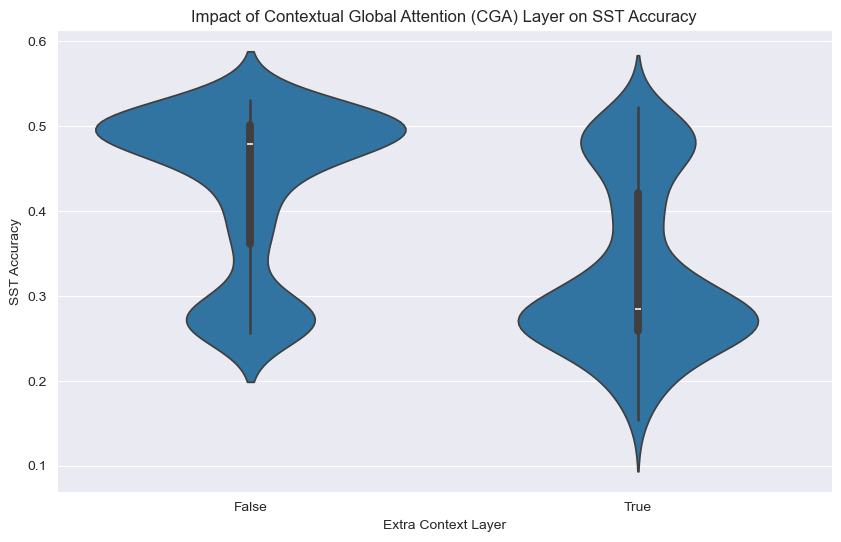

In [19]:
# 3. Impact of Global Context Layer
print("\n3. Impact of Global Context Layer")
context_impact = df.groupby('extra_context_layer').agg({'sst_accuracy': ['mean', 'max']})
print("SST Accuracy with and without Global Context Layer:")
print(context_impact)

plt.figure(figsize=(10, 6))
sns.violinplot(x='extra_context_layer', y='sst_accuracy', data=df, inner="box")
plt.title('Impact of Contextual Global Attention (CGA) Layer on SST Accuracy')
plt.ylabel('SST Accuracy')
plt.xlabel('Extra Context Layer')
plt.show()

## 4. Effectiveness of Pooling Strategies


4. Effectiveness of Pooling Strategies
SST Accuracy by Pooling Strategy:
                 sst_accuracy          
                         mean       max
pooling_strategy                       
cls                  0.380043  0.530233
attention            0.373463  0.522199
max                  0.384875  0.519239
average              0.383364  0.510782


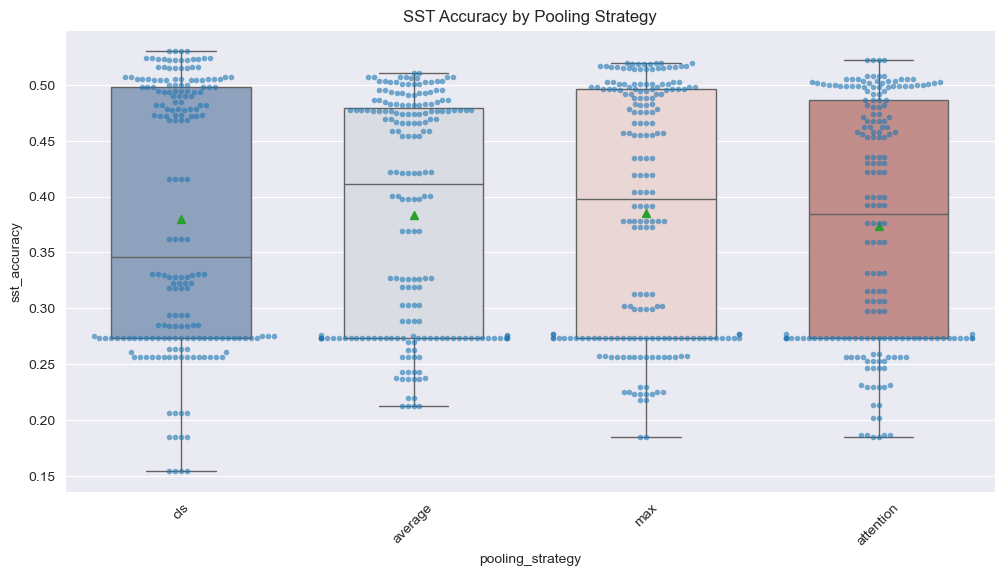

In [20]:
# 4. Effectiveness of Pooling Strategies
print("\n4. Effectiveness of Pooling Strategies")
pooling_performance = df.groupby('pooling_strategy').agg({'sst_accuracy': ['mean', 'max']}).sort_values(('sst_accuracy', 'max'), ascending=False)
print("SST Accuracy by Pooling Strategy:")
print(pooling_performance)

plt.figure(figsize=(12, 6))
sns.swarmplot(x='pooling_strategy', y='sst_accuracy', data=df, size=4, alpha=0.6)
sns.boxplot(x='pooling_strategy', y='sst_accuracy', hue='pooling_strategy', data=df, whis=[0, 100], width=.6, palette="vlag", showmeans=True, legend=False)
plt.title('SST Accuracy by Pooling Strategy')
plt.xticks(rotation=45)
plt.show()

## 5. Effect of Context-Aware Layers and Attention Pooling on SST Performance (add)


5. Effect of Context-Aware Layers and Attention Pooling on SST Performance
Best SST Performance with Extra CGA Layer:
sst_accuracy           0.522622
pooling_strategy            cls
regularize_context         True
learning_rate           0.00001
hidden_dropout_prob         0.5
batch_size                   64
optimizer                 adamw
epochs                        5
Name: 404, dtype: object

Best SST Performance with Attention Pooling:
sst_accuracy            0.522199
pooling_strategy       attention
regularize_context          True
learning_rate            0.00001
hidden_dropout_prob          0.5
batch_size                    64
optimizer                  adamw
epochs                         5
Name: 356, dtype: object

Best SST Performance with Both Extra Context Layer and Attention Pooling:
sst_accuracy           0.504863
regularize_context         True
learning_rate           0.00001
hidden_dropout_prob         0.3
batch_size                   64
optimizer                 adam

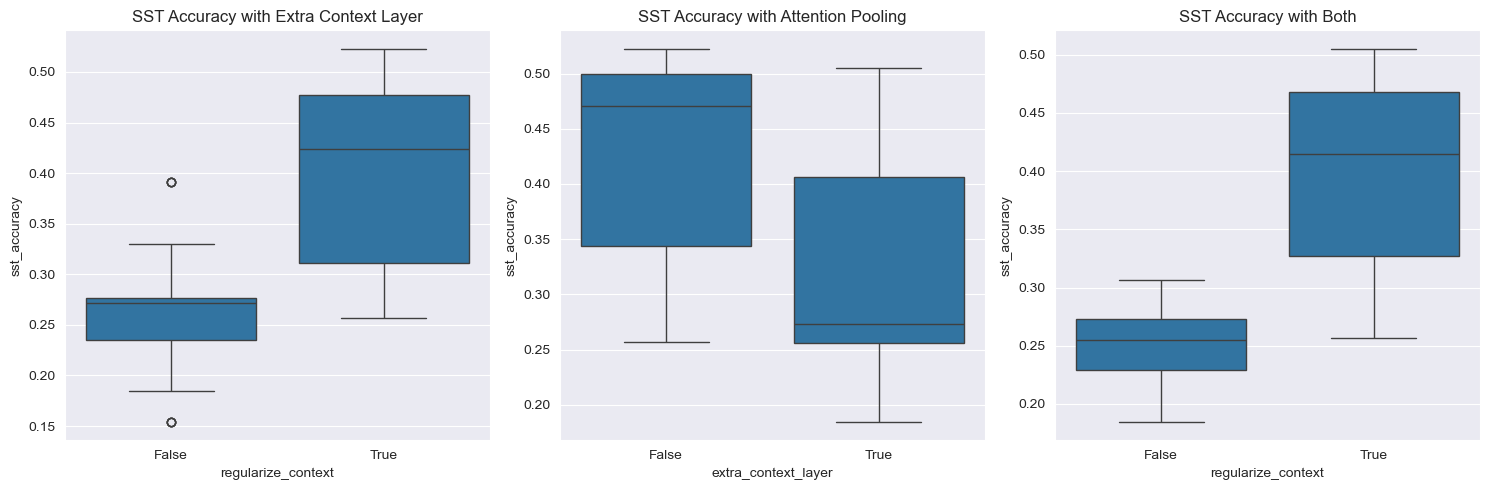

In [21]:
# 5. Effect of Context-Aware Layers and Attention Pooling on SST Performance
print("\n5. Effect of Context-Aware Layers and Attention Pooling on SST Performance")

# Case 1: Extra context layer is True
extra_context = df[df['extra_context_layer'] == True]
best_extra_context = extra_context.loc[extra_context['sst_accuracy'].idxmax()]
print("Best SST Performance with Extra CGA Layer:")
print(best_extra_context[['sst_accuracy', 'pooling_strategy', 'regularize_context', 'learning_rate', 'hidden_dropout_prob', 'batch_size', 'optimizer', 'epochs']])

# Case 2: Pooling strategy is attention
attention_pooling = df[df['pooling_strategy'] == 'attention']
best_attention = attention_pooling.loc[attention_pooling['sst_accuracy'].idxmax()]
print("\nBest SST Performance with Attention Pooling:")
print(best_attention[['sst_accuracy', 'pooling_strategy', 'regularize_context', 'learning_rate', 'hidden_dropout_prob', 'batch_size', 'optimizer', 'epochs']])

# Case 3: Both extra context layer and attention pooling
both_cases = df[(df['extra_context_layer'] == True) & (df['pooling_strategy'] == 'attention')]
best_both = both_cases.loc[both_cases['sst_accuracy'].idxmax()]
print("\nBest SST Performance with Both Extra Context Layer and Attention Pooling:")
print(best_both[['sst_accuracy', 'regularize_context', 'learning_rate', 'hidden_dropout_prob', 'batch_size', 'optimizer', 'epochs']])

# Visualizations
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='regularize_context', y='sst_accuracy', data=extra_context)
plt.title('SST Accuracy with Extra Context Layer')

plt.subplot(1, 3, 2)
sns.boxplot(x='extra_context_layer', y='sst_accuracy', data=attention_pooling)
plt.title('SST Accuracy with Attention Pooling')

plt.subplot(1, 3, 3)
sns.boxplot(x='regularize_context', y='sst_accuracy', data=both_cases)
plt.title('SST Accuracy with Both')

plt.tight_layout()
plt.show()

## 6. Overall Best SST Performances

In [22]:
# 6. Overall Best SST Performances
print("\n1. Top SST Performances")
top_sst = get_top_performers(df, 'sst_accuracy', threshold=0.001)
print(f"Top performances (within 0.01 of the best score):")
print(top_sst[['sst_accuracy', 'pooling_strategy', 'extra_context_layer', 'regularize_context', 'learning_rate', 'hidden_dropout_prob', 'batch_size', 'optimizer', 'epochs']])


1. Top SST Performances
Top performances (within 0.01 of the best score):
     sst_accuracy pooling_strategy  extra_context_layer  regularize_context  \
200      0.530233              cls                False                True   
201      0.530233              cls                False                True   
202      0.530233              cls                False                True   
203      0.530233              cls                False                True   

     learning_rate  hidden_dropout_prob  batch_size optimizer  epochs  
200        0.00001                  0.3          64     adamw       5  
201        0.00001                  0.3          64    sophia       5  
202        0.00001                  0.3          64     adamw      10  
203        0.00001                  0.3          64    sophia      10  
